In [286]:
using Plots
@time include("../src/federn/federn.jl");

  3.447491 seconds (21.94 M allocations: 592.619 MB, 23.03% gc time)


In [ ]:
#switch between peturbed and unperturbed Lzz versions

#Lzz = [rho_error(z-z2) for z in zs, z2 in zs] # unperturbed
#Lzz = [rho_error(z-z2) for z in zps, z2 in zs]  # perturbed


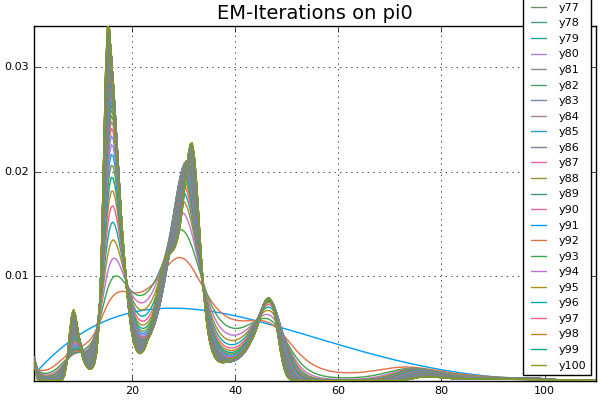

In [287]:
# define beta distribution prior, and get corresponding sampling weights
s = xmax+1
pi_0(x) = (x/s).*(1-x/s).^3.*(x/s.>0).*(x/s.<1)*20/s
betaw=map(pi_0, samples)
betaw=betaw/sum(betaw)

w0 = betaw

title = "EM-Iterations on pi0"
plot(samples, ws_em(betaw, 100), title=title)

In [288]:
# compare different zentropies
randw = rand(300)
randw = randw/sum(randw)
unitw = ones(300) / 300

@show zentropy(randw)
@show zentropy(unitw)
@show zentropy(betaw)

zentropy(randw) = 5.948015412799982
zentropy(unitw) = 5.904013119124532
zentropy(betaw) = 5.953722224165041


5.953722224165041

In [289]:
# dictionary for different weightings
wdict = Dict{String, Vector{Vector{Float64}}}()
niter = 50;

In [290]:
# gradientascent penalized max. likelihood
# with stepsize `h` and entropy weighting `s`
gapml(w0, niter, h=1, s=1) = gradientascent(x->pml(x,s), w0, niter, h, GynC.projectsimplex)

gapml (generic function with 3 methods)

In [ ]:
wdict["em"]  = ws_em(w0, niter)
wdict["pml e-7"] =     gapml(w0, niter, 0.0000001)
wdict["pml e-6"] =     gapml(w0, niter, 0.000001)
wdict["pml e-6 se1"] = gapml(w0, niter, 0.000001, 10)
wdict["pml e-6 se3"] = gapml(w0, niter, 0.000001, 1000)
wdict["l   e-6  s0"] = gapml(w0, niter, 0.000001, 0)
wdict["ze e-3"] = gradientascent(x->zentropy(x), w0, niter, 0.001, GynC.projectsimplex)


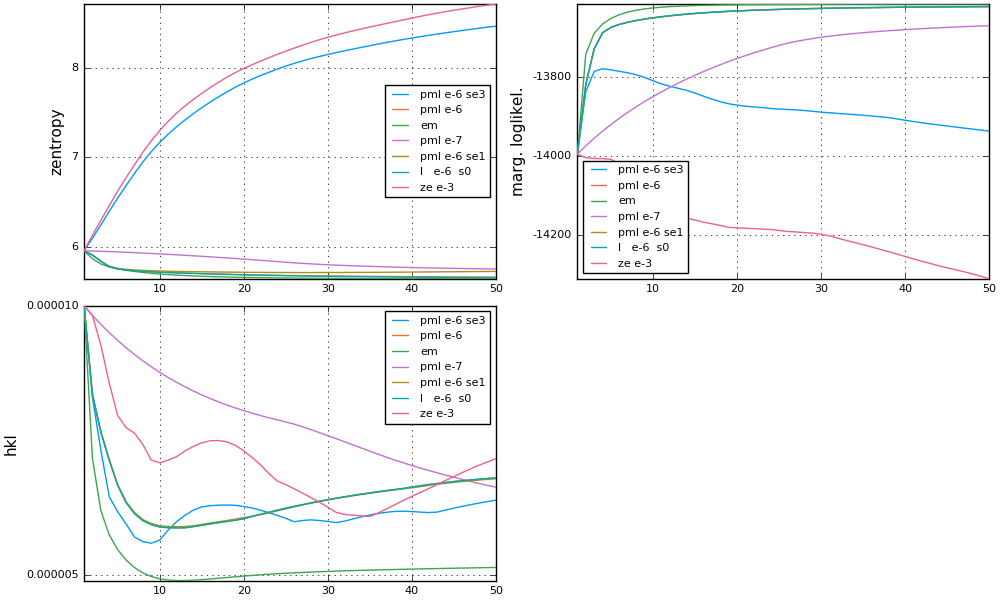

In [292]:
zeplot = plot(yaxis="zentropy")
mlplot = plot(yaxis="marg. loglikel.")
hklplot = plot(yaxis="hkl")

for (key, ws) in wdict
    plot!(zeplot, map(zentropy, ws), label=key)
    plot!(mlplot, map(marginallikelihood, ws), label=key)
    plot!(hklplot, map(w->HKL(w,Lzz,zehnfach(w)), ws), label=key)
end
plot(zeplot, mlplot, hklplot, size=(1000,600))


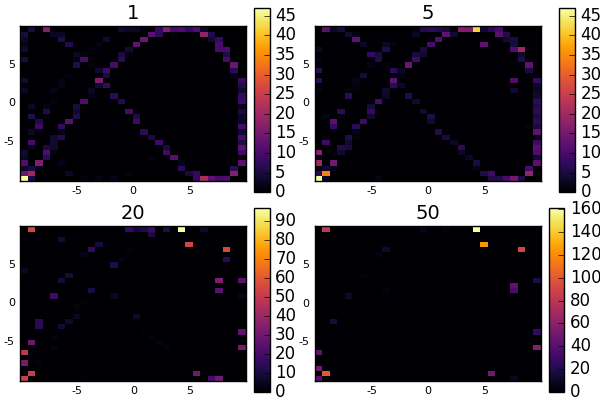

In [294]:
ww=wdict["ze e-3"]

function zplot(w; args...)
    zsmpls = sample(GynC.WeightedSampling(zs, w), 1000)
    histogram2d(map(x->x[1], zsmpls), map(x->x[2], zsmpls); args...)
end
plot([zplot(ww[i], title=i) for i=[1,5,20,50]]...)


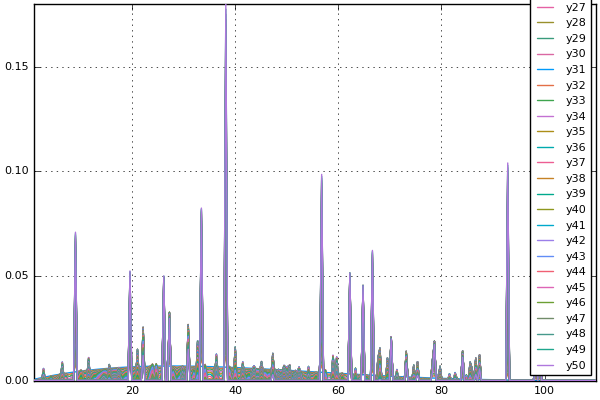

In [295]:
function plotiters(ws; kwargs...)
    plot(samples,hcat(ws...), kwargs...)
end

plotiters(ww)


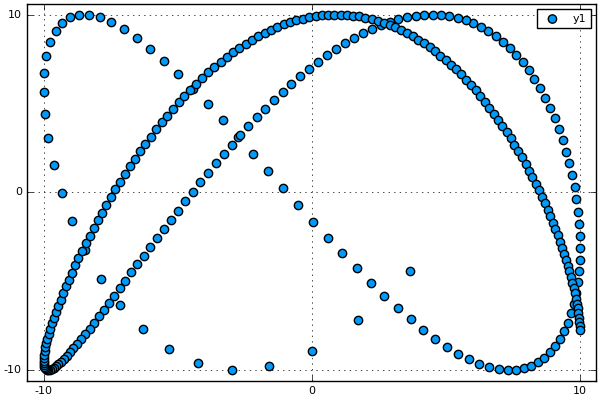

In [221]:
temp = hcat(zs...)
scatter(temp[1,:],temp[2,:])


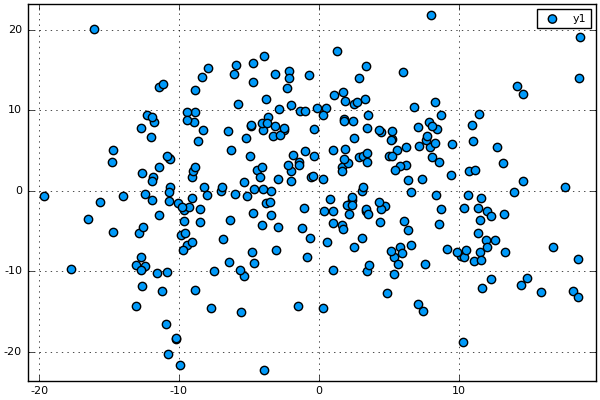

In [299]:
temp = hcat(zps...)
scatter(temp[1,:],temp[2,:])

In [300]:
# generate multiple, perturbed z-meas. per x 

nerrspl = 20

ntimes(w,n) = repeat(w, inner=[n])
ntimespert(zs, n) = map(x -> x+randn(2) * rho_std, ntimes(zs, n));

# adapt the Lzz matrix
Lzz = [rho_error(z-zp) for zp in ntimespert(zs, nerrspl), z in zs];

348.072660 seconds (1.63 G allocations: 145.506 GB, 46.74% gc time)



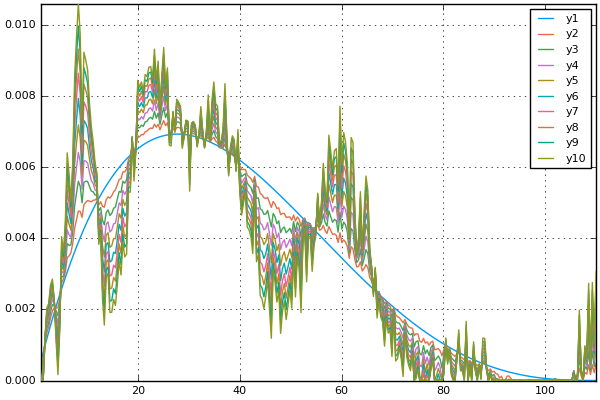

In [301]:
include("../src/optim3.jl")
gahkl(w0, niter, h=1, s=1) = gradientascent(w->HKL(w, Lzz, ntimes(w, nerrspl)), w0, niter, h, GynC.projectsimplex)

@time hkl = gahkl(w0, 10, 1e2);

plotiters(hkl)

In [ ]:
# ^^ seems to approach the solutions for zps = zs